### Problem Statment:

##### Identify new set of accounts which has the more likely behaviour to buy "Product E" from non purchased category of accounts and rank them form very high to low.
##### Data Set:
1.Id  - This is a unique Id for each account
Website Vistis - No. of weviste visits made by each account
2.Industry - The business sector the account is operating
3.Category - This indicates whether account is a Customer, Partner & prospect
4.Segment - This indicates size of industry the accounts belongs to Enterprise, Medium & Small
5.Type - Yes - Named, No - Non Named 
6.Revenue - Total revenue for the customer
7.Prd-A -  Product A
8.Prd-B - Product B
9.Day - last contact day of the month (numeric)
10.Month - last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
11.Duration - last contact duration, in seconds (numeric)
12.Campaign - number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.Pdays - number of days that passed by after the client was last contacted from a previous 14.campaign (numeric, -1 means client was not previously contacted)
15.Previous - number of contacts performed before this campaign and for this client (numeric)
16.Poutcome - outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
17.Prd-E - This is the product used for propensity prediction


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

In [130]:
data_df = pd.read_csv("C:\\Users\\antot\\OneDrive\\Desktop\Personal\RH\LR\\LR Data_v2.csv")

In [4]:
###EDA

In [131]:
data_df.head()

,ID,website Vistis,Industry,Category,Segment,Type,Revenue,Prd-A,Prd-B,day,month,duration,campaign,pdays,previous,poutcome,Prd-E
0,1001,30,Hospitality,Customer,Medium,Non-Named,1787,yes,no,19,oct,79,1,-1,0,unknown,yes
1,1002,33,Government,Customer,Small,Non-Named,4789,yes,yes,11,may,220,1,339,4,failure,yes
2,1003,35,Education,Prospect,Enterprise,Non-Named,1350,yes,no,16,apr,185,1,330,1,failure,yes
3,1004,30,Education,Customer,Enterprise,Non-Named,1476,yes,yes,3,jun,199,4,-1,0,unknown,yes
4,1005,59,Banking,Customer,Small,Non-Named,1123,yes,no,5,may,226,1,-1,0,unknown,yes


In [132]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              499 non-null    int64 
 1   website Vistis  499 non-null    int64 
 2   Industry        499 non-null    object
 3   Category        499 non-null    object
 4   Segment         499 non-null    object
 5   Type            499 non-null    object
 6   Revenue         499 non-null    int64 
 7   Prd-A           499 non-null    object
 8   Prd-B           499 non-null    object
 9   day             499 non-null    int64 
 10  month           499 non-null    object
 11  duration        499 non-null    int64 
 12  campaign        499 non-null    int64 
 13  pdays           499 non-null    int64 
 14  previous        499 non-null    int64 
 15  poutcome        499 non-null    object
 16  Prd-E           499 non-null    object
dtypes: int64(8), object(9)
memory usage: 66.4+ KB


In [133]:
df = data_df.drop(['ID'], axis =1)

### Check for duplicated data

In [134]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(data_df.shape)

Number of duplicate rows = 0
(499, 17)


##### There are no duplicates

In [27]:
### Getting unique count for all the objects

In [135]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print(feature)
        print(df[feature].value_counts())
        print('\n')

Industry
Education           106
Banking             104
Retail               84
Hitech               58
Government           40
Energy               27
Manufacturing        26
Hospitality          17
Business Service     17
Telecom              11
Healthcare            9
Name: Industry, dtype: int64


Category
Customer    353
Prospect     93
Partner      53
Name: Category, dtype: int64


Segment
Small         248
Enterprise    157
Medium         94
Name: Segment, dtype: int64


Type
Non-Named    487
Named         12
Name: Type, dtype: int64


Prd-A
yes    344
no     155
Name: Prd-A, dtype: int64


Prd-B
no     321
yes    178
Name: Prd-B, dtype: int64


month
may    146
jul     85
aug     68
jun     51
nov     48
apr     36
feb     28
jan     16
oct      8
sep      7
mar      5
dec      1
Name: month, dtype: int64


poutcome
unknown    400
failure     64
success     18
other       17
Name: poutcome, dtype: int64


Prd-E
no     359
yes    140
Name: Prd-E, dtype: int64




### Checking for outliers

<AxesSubplot:>

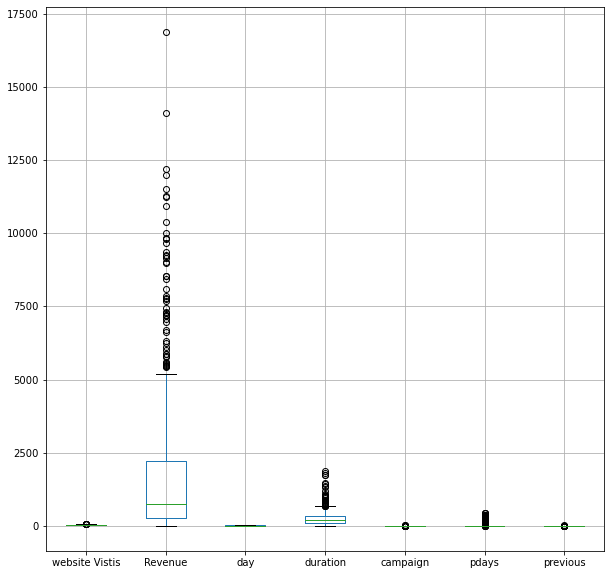

In [136]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
df.boxplot()

In [34]:
## Treating outliers

In [137]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [138]:
for column in df.columns:
    if df[column].dtype != 'object': 
        lr,ur=remove_outlier(df[column])
        df[column]=np.where(df[column]>ur,ur,df[column])
        df[column]=np.where(df[column]<lr,lr,df[column])

<AxesSubplot:>

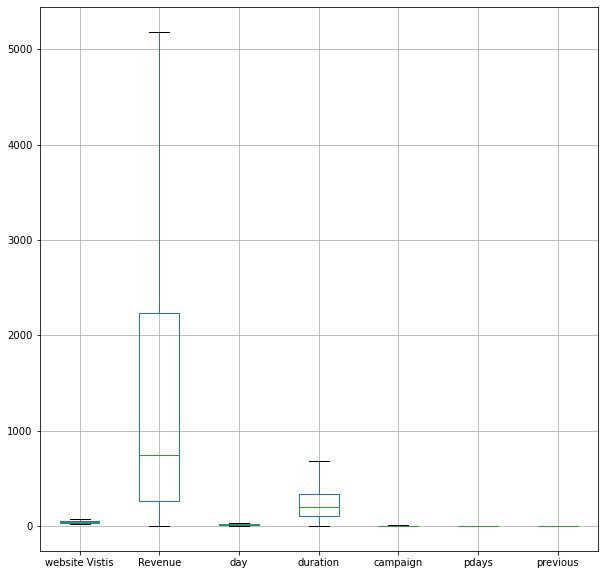

In [139]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
df.boxplot()

### Checking for correlations

<AxesSubplot:>

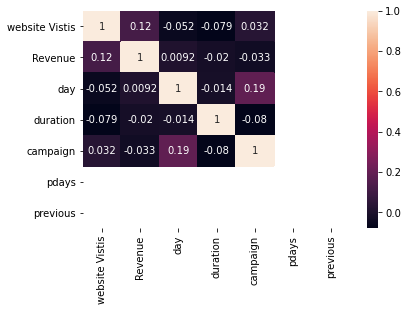

In [140]:
sns.heatmap(df.corr(), annot=True)

### there are no correlations

In [141]:
df.describe()

,website Vistis,Revenue,day,duration,campaign,pdays,previous
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.0,499.0
mean,41.212425,1531.699399,15.787575,247.589178,2.280561,-1.0,0.0
std,10.484975,1722.652301,8.213453,186.668073,1.478576,0.0,0.0
min,20.000000,1.000000,1.000000,5.000000,1.000000,-1.0,0.0
25%,33.000000,260.500000,9.000000,109.000000,1.000000,-1.0,0.0
50%,39.000000,741.000000,16.000000,196.000000,2.000000,-1.0,0.0
75%,49.000000,2230.000000,21.000000,340.000000,3.000000,-1.0,0.0
max,73.000000,5184.250000,31.000000,686.500000,6.000000,-1.0,0.0


In [ ]:
## The attribute previous is zero & pdays is -1 after removing outliers

In [142]:
df.drop(['previous','pdays'],axis =1)

,website Vistis,Industry,Category,Segment,Type,Revenue,Prd-A,Prd-B,day,month,duration,campaign,poutcome,Prd-E
0,30.0,Hospitality,Customer,Medium,Non-Named,1787.00,yes,no,19.0,oct,79.0,1.0,unknown,yes
1,33.0,Government,Customer,Small,Non-Named,4789.00,yes,yes,11.0,may,220.0,1.0,failure,yes
2,35.0,Education,Prospect,Enterprise,Non-Named,1350.00,yes,no,16.0,apr,185.0,1.0,failure,yes
3,30.0,Education,Customer,Enterprise,Non-Named,1476.00,yes,yes,3.0,jun,199.0,4.0,unknown,yes
4,59.0,Banking,Customer,Small,Non-Named,1123.00,yes,no,5.0,may,226.0,1.0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,44.0,Retail,Prospect,Small,Non-Named,244.00,yes,no,12.0,aug,686.5,4.0,unknown,no
495,48.0,Education,Partner,Enterprise,Non-Named,1328.00,yes,no,6.0,may,339.0,1.0,unknown,no
496,50.0,Telecom,Customer,Small,Non-Named,5184.25,yes,no,13.0,may,172.0,1.0,failure,no
497,34.0,Retail,Prospect,Small,Non-Named,4943.00,yes,yes,19.0,nov,117.0,2.0,unknown,no


<AxesSubplot:>

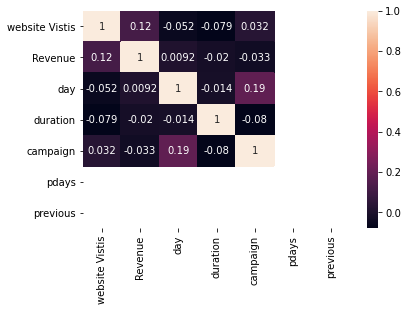

In [143]:
sns.heatmap(df.corr(), annot=True)

### Converting all objects to categorical codes

In [144]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df[feature].unique()))
        print(pd.Categorical(df[feature].unique()).codes)
        df[feature] = pd.Categorical(df[feature]).codes



feature: Industry
['Hospitality', 'Government', 'Education', 'Banking', 'Manufacturing', ..., 'Business Service', 'Hitech', 'Healthcare', 'Telecom', 'Energy']
Length: 11
Categories (11, object): ['Banking', 'Business Service', 'Education', 'Energy', ..., 'Hospitality', 'Manufacturing', 'Retail', 'Telecom']
[ 7  4  2  0  8  9  1  6  5 10  3]


feature: Category
['Customer', 'Prospect', 'Partner']
Categories (3, object): ['Customer', 'Partner', 'Prospect']
[0 2 1]


feature: Segment
['Medium', 'Small', 'Enterprise']
Categories (3, object): ['Enterprise', 'Medium', 'Small']
[1 2 0]


feature: Type
['Non-Named', 'Named']
Categories (2, object): ['Named', 'Non-Named']
[1 0]


feature: Prd-A
['yes', 'no']
Categories (2, object): ['no', 'yes']
[1 0]


feature: Prd-B
['no', 'yes']
Categories (2, object): ['no', 'yes']
[0 1]


feature: month
['oct', 'may', 'apr', 'jun', 'feb', ..., 'jul', 'nov', 'sep', 'mar', 'dec']
Length: 12
Categories (12, object): ['apr', 'aug', 'dec', 'feb', ..., 'may', 

In [145]:
df.head()

,website Vistis,Industry,Category,Segment,Type,Revenue,Prd-A,Prd-B,day,month,duration,campaign,pdays,previous,poutcome,Prd-E
0,30.0,7,0,1,1,1787.0,1,0,19.0,10,79.0,1.0,-1.0,0.0,3,1
1,33.0,4,0,2,1,4789.0,1,1,11.0,8,220.0,1.0,-1.0,0.0,0,1
2,35.0,2,2,0,1,1350.0,1,0,16.0,0,185.0,1.0,-1.0,0.0,0,1
3,30.0,2,0,0,1,1476.0,1,1,3.0,6,199.0,4.0,-1.0,0.0,3,1
4,59.0,0,0,2,1,1123.0,1,0,5.0,8,226.0,1.0,-1.0,0.0,3,1


In [146]:
df.drop(['previous','pdays'],axis =1)

,website Vistis,Industry,Category,Segment,Type,Revenue,Prd-A,Prd-B,day,month,duration,campaign,poutcome,Prd-E
0,30.0,7,0,1,1,1787.00,1,0,19.0,10,79.0,1.0,3,1
1,33.0,4,0,2,1,4789.00,1,1,11.0,8,220.0,1.0,0,1
2,35.0,2,2,0,1,1350.00,1,0,16.0,0,185.0,1.0,0,1
3,30.0,2,0,0,1,1476.00,1,1,3.0,6,199.0,4.0,3,1
4,59.0,0,0,2,1,1123.00,1,0,5.0,8,226.0,1.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,44.0,9,2,2,1,244.00,1,0,12.0,1,686.5,4.0,3,0
495,48.0,2,1,0,1,1328.00,1,0,6.0,8,339.0,1.0,3,0
496,50.0,10,0,2,1,5184.25,1,0,13.0,8,172.0,1.0,0,0
497,34.0,9,2,2,1,4943.00,1,1,19.0,9,117.0,2.0,3,0


### Train and Test Split

In [147]:
# Copy all the predictor variables into X dataframe
X = df.drop('Prd-E', axis=1)

# Copy target into the y dataframe. 
y = df[['Prd-E']]

In [148]:
# Split X and y into training and test set in 80:20 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20 , random_state=1)

### Logistic Regression Model

In [149]:
# Fit the Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
model_score_train_LR = model_LR.score(X_train, y_train)

y_predict_train = model_LR.predict(X_train)
model_score_train_LR = model_LR.score(X_train, y_train)
print('Train: %.3f' % model_score_train_LR)
print(metrics.confusion_matrix(y_train, y_predict_train))
print(metrics.classification_report(y_train, y_predict_train))

y_predict_test = model_LR.predict(X_test)
model_score_test_LR = model_LR.score(X_test, y_test)
print('Test: %.3f' % model_score_test_LR)
print(metrics.confusion_matrix(y_test, y_predict_test))
print(metrics.classification_report(y_test, y_predict_test))

model_LR.fit(X, y)
model_score_LR = model_LR.score(X, y)
y_predict = model_LR.predict(X)
print('Complete: %.3f' % model_score_LR)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\antot\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.744
[[268  19]
 [ 83  29]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       287
           1       0.60      0.26      0.36       112

    accuracy                           0.74       399
   macro avg       0.68      0.60      0.60       399
weighted avg       0.72      0.74      0.71       399

Test: 0.720
[[65  7]
 [21  7]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.82        72
           1       0.50      0.25      0.33        28

    accuracy                           0.72       100
   macro avg       0.63      0.58      0.58       100
weighted avg       0.68      0.72      0.69       100

Complete: 0.721
[[331  28]
 [111  29]]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       359
           1       0.51      0.21      0.29       140

    accuracy                           0.72       499
   macro avg       0.6

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\antot\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Model

In [150]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
# Finding best parameter
from sklearn.model_selection import GridSearchCV

In [151]:
param_grid = {
    'max_depth': [7,10],
    'max_features':[4,6],
    'min_samples_leaf':[50,100],
    'n_estimators':[301,501]
}

In [152]:
rfcl = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid , cv=3)
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 10], 'max_features': [4, 6],
                         'min_samples_leaf': [50, 100],
                         'n_estimators': [301, 501]})

In [153]:
best_grid = grid_search.best_estimator_

In [154]:
## CM for RF

model_RF = best_grid.fit(X_train,y_train)
ytest_predict= model_RF.predict(X_test)
ytrain_predict= model_RF.predict(X_train)
# Train Set
model_score = model_RF.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, ytrain_predict))
print(metrics.classification_report(y_train, ytrain_predict))

# Test Set
model_score = model_RF.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, ytest_predict))
print(metrics.classification_report(y_test, ytest_predict))

# Complete data Set
model_RF = best_grid.fit(X,y)
y_predict= model_RF.predict(X)
model_score = model_RF.score(X, y_predict)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

<ipython-input-154-4ac229a65d17>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RF = best_grid.fit(X_train,y_train)


Train: 0.719
[[287   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       287
           1       0.00      0.00      0.00       112

    accuracy                           0.72       399
   macro avg       0.36      0.50      0.42       399
weighted avg       0.52      0.72      0.60       399

Test: 0.720
[[72  0]
 [28  0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        72
           1       0.00      0.00      0.00        28

    accuracy                           0.72       100
   macro avg       0.36      0.50      0.42       100
weighted avg       0.52      0.72      0.60       100



C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metr

Complete: 1.000
[[359   0]
 [140   0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       359
           1       0.00      0.00      0.00       140

    accuracy                           0.72       499
   macro avg       0.36      0.50      0.42       499
weighted avg       0.52      0.72      0.60       499

Complete:
Sensitivity :  1.0
Specificity :  0.0
Precision :  nan


C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-154-4ac229a65d17>:34: RuntimeWarning: in

### Naive Bayes Model

In [155]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [156]:
NB_model = GaussianNB()
NB_model_fit = NB_model.fit(X_train, y_train)
y_train_predict = NB_model_fit.predict(X_train)
model_score = NB_model_fit.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

y_test_predict = NB_model_fit.predict(X_test)
model_score = NB_model_fit.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

NB_model_fit_1 = NB_model.fit(X, y)
y_predict = NB_model_fit_1.predict(X)
model_score = NB_model_fit_1.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.704
[[229  58]
 [ 60  52]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       287
           1       0.47      0.46      0.47       112

    accuracy                           0.70       399
   macro avg       0.63      0.63      0.63       399
weighted avg       0.70      0.70      0.70       399

Test: 0.670
[[54 18]
 [15 13]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        72
           1       0.42      0.46      0.44        28

    accuracy                           0.67       100
   macro avg       0.60      0.61      0.60       100
weighted avg       0.68      0.67      0.67       100

Complete: 0.711
[[287  72]
 [ 72  68]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       359
           1       0.49      0.49      0.49       140

    accuracy                           0.71       499
   macro avg       0.6

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### SVM

In [157]:
from sklearn import svm

SVM_model= svm.SVC(random_state=1)
SVM_model_fit = SVM_model.fit(X_train, y_train)

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [158]:
## Performance matrix on train data set
y_train_predict = SVM_model_fit.predict(X_train)
model_score = SVM_model_fit.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance matrix on test data set
y_test_predict = SVM_model_fit.predict(X_test)
model_score = SVM_model_fit.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_predict = SVM_model.predict(X)
model_score = SVM_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.719
[[287   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       287
           1       0.00      0.00      0.00       112

    accuracy                           0.72       399
   macro avg       0.36      0.50      0.42       399
weighted avg       0.52      0.72      0.60       399

Test: 0.720
[[72  0]
 [28  0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        72
           1       0.00      0.00      0.00        28

    accuracy                           0.72       100
   macro avg       0.36      0.50      0.42       100
weighted avg       0.52      0.72      0.60       100

Complete: 0.719
[[359   0]
 [140   0]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       359
           1       0.00      0.00      0.00       140

    accuracy                           0.72       499
   macro avg       0.3

C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antot\anaconda3\lib\site-packages\sklearn\metr

### Boosting

In [186]:
from sklearn.ensemble import AdaBoostClassifier

ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model_fit = ADB_model.fit(X_train,y_train)

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [187]:
## Performance Matrix on test data set
y_train_predict = ADB_model.predict(X_train)
model_score = ADB_model.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance Matrix on test data set
y_test_predict = ADB_model.predict(X_test)
model_score = ADB_model.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_ADB_predict = ADB_model.predict(X)
model_score = ADB_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_ADB_predict))
print(metrics.classification_report(y, y_ADB_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : %.3f' % precision)

Train: 0.822
[[266  21]
 [ 50  62]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       287
           1       0.75      0.55      0.64       112

    accuracy                           0.82       399
   macro avg       0.79      0.74      0.76       399
weighted avg       0.82      0.82      0.81       399

Test: 0.740
[[65  7]
 [19  9]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        72
           1       0.56      0.32      0.41        28

    accuracy                           0.74       100
   macro avg       0.67      0.61      0.62       100
weighted avg       0.71      0.74      0.71       100

Complete: 0.806
[[331  28]
 [ 69  71]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       359
           1       0.72      0.51      0.59       140

    accuracy                           0.81       499
   macro avg       0.7

### XG Boost

In [166]:
import xgboost as xgb
XGB_model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_model_fit = XGB_model.fit(X_train, y_train)

[16:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\antot\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [167]:
## Performance matrix on train data set

y_train_predict = XGB_model_fit.predict(X_train)
model_score = XGB_model_fit.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance Matrix on test data set
y_test_predict = XGB_model_fit.predict(X_test)
model_score = XGB_model_fit.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_predict = XGB_model.predict(X)
model_score = XGB_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.865
[[275  12]
 [ 42  70]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       287
           1       0.85      0.62      0.72       112

    accuracy                           0.86       399
   macro avg       0.86      0.79      0.82       399
weighted avg       0.86      0.86      0.86       399

Test: 0.740
[[65  7]
 [19  9]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        72
           1       0.56      0.32      0.41        28

    accuracy                           0.74       100
   macro avg       0.67      0.61      0.62       100
weighted avg       0.71      0.74      0.71       100

Complete: 0.840
[[340  19]
 [ 61  79]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.89       359
           1       0.81      0.56      0.66       140

    accuracy                           0.84       499
   macro avg       0.8

### KNN

In [168]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier()
KNN_model_fit = KNN_model.fit(X_train,y_train)

C:\Users\antot\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [169]:
## Performance matrix on train data set

y_train_predict = KNN_model_fit.predict(X_train)
model_score = KNN_model_fit.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance Matrix on test data set
y_test_predict = KNN_model_fit.predict(X_test)
model_score = KNN_model_fit.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_predict = KNN_model.predict(X)
model_score = KNN_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.777
[[267  20]
 [ 69  43]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       287
           1       0.68      0.38      0.49       112

    accuracy                           0.78       399
   macro avg       0.74      0.66      0.67       399
weighted avg       0.76      0.78      0.75       399

Test: 0.670
[[61 11]
 [22  6]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79        72
           1       0.35      0.21      0.27        28

    accuracy                           0.67       100
   macro avg       0.54      0.53      0.53       100
weighted avg       0.63      0.67      0.64       100

Complete: 0.756
[[328  31]
 [ 91  49]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       359
           1       0.61      0.35      0.45       140

    accuracy                           0.76       499
   macro avg       0.7

#### LDA

In [170]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [171]:
# Model Building
model_LDA = LinearDiscriminantAnalysis()
model_LDA_fit = model_LDA.fit(X_train, y_train)


## Performance matrix on train data set

y_train_predict = model_LDA_fit.predict(X_train)
model_score = model_LDA_fit.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance Matrix on test data set
y_test_predict = model_LDA_fit.predict(X_test)
model_score = model_LDA_fit.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))


## Performance Matrix on complete data set
y_predict = model_LDA_fit.predict(X)
model_score = model_LDA_fit.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.769
[[272  15]
 [ 77  35]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       287
           1       0.70      0.31      0.43       112

    accuracy                           0.77       399
   macro avg       0.74      0.63      0.64       399
weighted avg       0.76      0.77      0.74       399

Test: 0.750
[[66  6]
 [19  9]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        72
           1       0.60      0.32      0.42        28

    accuracy                           0.75       100
   macro avg       0.69      0.62      0.63       100
weighted avg       0.73      0.75      0.72       100

Complete: 0.766
[[338  21]
 [ 96  44]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       359
           1       0.68      0.31      0.43       140

    accuracy                           0.77       499
   macro avg       0.7

C:\Users\antot\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## SMOTE

In [172]:
from imblearn.over_sampling import SMOTE
## SMOTE is only applied on the train data set
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.values.ravel())

In [173]:
X_train_res.shape

(574, 15)

#### Naive Bayes with SMOTE

In [178]:
NB_SM_model = GaussianNB()
NB_SM_model.fit(X_train_res, y_train_res)

GaussianNB()

In [179]:
## Performance Matrix on train data set with SMOTE
y_train_predict = NB_SM_model.predict(X_train_res)
model_score = NB_SM_model.score(X_train_res, y_train_res)


## Performance matrix on train data set

y_train_predict = NB_SM_model.predict(X_train)
model_score = NB_SM_model.score(X_train, y_train)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

## Performance Matrix on test data set
y_test_predict = NB_SM_model.predict(X_test)
model_score = NB_SM_model.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))


## Performance Matrix on complete data set
y_predict = NB_SM_model.predict(X)
model_score = NB_SM_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.669
[[200  87]
 [ 45  67]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       287
           1       0.44      0.60      0.50       112

    accuracy                           0.67       399
   macro avg       0.63      0.65      0.63       399
weighted avg       0.71      0.67      0.68       399

Test: 0.690
[[51 21]
 [10 18]]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        72
           1       0.46      0.64      0.54        28

    accuracy                           0.69       100
   macro avg       0.65      0.68      0.65       100
weighted avg       0.73      0.69      0.70       100

Complete: 0.673
[[251 108]
 [ 55  85]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       359
           1       0.44      0.61      0.51       140

    accuracy                           0.67       499
   macro avg       0.6

#### ADA Boost with SMOTE

In [188]:
## ADA Boost with SMOTE
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model_fit = ADB_model.fit(X_train_res,y_train_res)

## Performance Matrix on test data set
y_train_res_predict = ADB_model_fit.predict(X_train_res)
model_score = ADB_model.score(X_train_res, y_train_res)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train_res, y_train_res_predict))
print(metrics.classification_report(y_train_res, y_train_res_predict))

## Performance Matrix on test data set
y_test_predict = ADB_model.predict(X_test)
model_score = ADB_model.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_predict = ADB_model.predict(X)
model_score = ADB_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.841
[[238  49]
 [ 42 245]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       287
           1       0.83      0.85      0.84       287

    accuracy                           0.84       574
   macro avg       0.84      0.84      0.84       574
weighted avg       0.84      0.84      0.84       574

Test: 0.690
[[53 19]
 [12 16]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.77        72
           1       0.46      0.57      0.51        28

    accuracy                           0.69       100
   macro avg       0.64      0.65      0.64       100
weighted avg       0.72      0.69      0.70       100

Complete: 0.766
[[291  68]
 [ 49  91]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       359
           1       0.57      0.65      0.61       140

    accuracy                           0.77       499
   macro avg       0.7

In [ ]:
### ADASyn

In [181]:
from imblearn.over_sampling import ADASYN

In [182]:
## SMOTE is only applied on the train data set
X_train_res_AS, y_train_res_AS = ADASYN().fit_resample(X_train, y_train.values.ravel())

In [183]:
## ADA Boost with ADASYN
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model_fit = ADB_model.fit(X_train_res_AS,y_train_res_AS)

## Performance Matrix on train data set
y_train_res_AS_predict = ADB_model.predict(X_train_res_AS)
model_score = ADB_model.score(X_train_res_AS, y_train_res_AS)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train_res_AS, y_train_res_AS_predict))
print(metrics.classification_report(y_train_res_AS, y_train_res_AS_predict))

## Performance Matrix on test data set
y_test_predict = ADB_model.predict(X_test)
model_score = ADB_model.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

## Performance Matrix on complete data set
y_predict = ADB_model.predict(X)
model_score = ADB_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.860
[[244  43]
 [ 36 241]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       287
           1       0.85      0.87      0.86       277

    accuracy                           0.86       564
   macro avg       0.86      0.86      0.86       564
weighted avg       0.86      0.86      0.86       564

Test: 0.780
[[63  9]
 [13 15]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        72
           1       0.62      0.54      0.58        28

    accuracy                           0.78       100
   macro avg       0.73      0.71      0.71       100
weighted avg       0.77      0.78      0.77       100

Complete: 0.802
[[307  52]
 [ 47  93]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       359
           1       0.64      0.66      0.65       140

    accuracy                           0.80       499
   macro avg       0.7

### Naive bayes with ADAsyn

In [184]:
NB_SM_model = GaussianNB()
NB_SM_model.fit(X_train_res_AS, y_train_res_AS)

## Performance matrix on train data set

y_train_res_AS_predict = NB_SM_model.predict(X_train_res_AS)
model_score = NB_SM_model.score(X_train_res_AS, y_train_res_AS)
print('Train: %.3f' % model_score)
print(metrics.confusion_matrix(y_train_res_AS, y_train_res_AS_predict))
print(metrics.classification_report(y_train_res_AS, y_train_res_AS_predict))

## Performance Matrix on test data set
y_test_predict = NB_SM_model.predict(X_test)
model_score = NB_SM_model.score(X_test, y_test)
print('Test: %.3f' % model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))


## Performance Matrix on complete data set
y_predict = NB_SM_model.predict(X)
model_score = NB_SM_model.score(X, y)
print('Complete: %.3f' % model_score)
print(metrics.confusion_matrix(y, y_predict))
print(metrics.classification_report(y, y_predict))

CM_comp = metrics.confusion_matrix(y, y_predict)
sensitivity = CM_comp[0,0]/(CM_comp[0,0]+CM_comp[0,1])
print('Complete:')
print('Sensitivity : ', sensitivity )

specificity = CM_comp[1,1]/(CM_comp[1,0]+CM_comp[1,1])
print('Specificity : ', specificity)

precision = CM_comp[1,1]/(CM_comp[0,1]+CM_comp[1,1])
print('Precision : ', precision)

Train: 0.734
[[196  91]
 [ 59 218]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       287
           1       0.71      0.79      0.74       277

    accuracy                           0.73       564
   macro avg       0.74      0.73      0.73       564
weighted avg       0.74      0.73      0.73       564

Test: 0.680
[[49 23]
 [ 9 19]]
              precision    recall  f1-score   support

           0       0.84      0.68      0.75        72
           1       0.45      0.68      0.54        28

    accuracy                           0.68       100
   macro avg       0.65      0.68      0.65       100
weighted avg       0.73      0.68      0.69       100

Complete: 0.665
[[245 114]
 [ 53  87]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       359
           1       0.43      0.62      0.51       140

    accuracy                           0.67       499
   macro avg       0.6

In [185]:
# predict probabilities
probs = NB_SM_model.predict_proba(X)
prob = pd.DataFrame(probs)

y_NB_AS_predict_1 = pd.DataFrame(y_predict)
data_df ['y_predict_1'] = y_NB_AS_predict_1
data_df ['prob_0'] = prob [0]
data_df ['prob_1'] = prob [1]

data_df.to_csv ('C:\\Users\\antot\\OneDrive\\Desktop\\Personal\\RH\\LR\\Predicted_1.csv')

#### Conclusion

1. Out of the above models, Naive bayes with ADASYN over sampling method has classified higher number of accounts with precision of 43%.
2. We are considering this model to meet business objective i.e. identifying set of accounts which has the more probability of purchasing "product E" from the set of non purchased accounts.
3. This shows that , if we consider 359 accounts, out of this 114 has the probability to convert.
4. Out of 114, propensity has been distributed as Very High - 15, High - 65, Medium - 12, Low -22
5. Scale for propoensity Ranking, Very High - >90%, High - >70%, Medium - >60%, Low - >50%


Note -  Please refer Propensity ranking excel report for more details on model scores, predicted data set, propensity ranking split & base data.
